<h1> NEURAL NETWORK IMPLEMENTATION <h1>

<h2> IMPORTS <h2>

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# import cupy as cp
import sklearn
from sklearn.model_selection import train_test_split


<h2> IMPORTS AND SPLIT <h2>

In [16]:
import os
os.chdir(r"C:\Users\Salaar Masood\OneDrive - Higher Education Commission\ML (CS438)\Proj\Progress\Urdu-News-Classification") # change to whatever your dir is
path = r"dataset/cleaned_articles/cleaned_articles_with_numbers_v2.csv"
data = pd.read_csv(path)

In [17]:
X = data['content']
Y = data['gold_label']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"Y_train shape: {Y_train.shape}")
print(f"Y_test shape: {Y_test.shape}")


category_to_label = {
    "entertainment": 0,
    "business": 1,
    "sports": 2,
    "science-technology": 3,
    "international": 4
}

Y_train = [category_to_label[label.strip()] for label in Y_train if label.strip() in category_to_label]
Y_test = [category_to_label[label.strip()] for label in Y_test if label.strip() in category_to_label]


X_train shape: (2000,)
X_test shape: (501,)
Y_train shape: (2000,)
Y_test shape: (501,)


<h2> BAG OF WORDS <h2>

In [18]:
class TextProcessor:
    def __init__(self, dataset):
        self.dataset = dataset
        self.vocabulary = {}

    def build_vocabulary(self):
        unique_words = set()
        for sentence in self.dataset:
            unique_words.update(sentence.split())
        self.vocabulary = {word: idx for idx, word in enumerate(sorted(unique_words))}
        return self.vocabulary

    def sentence_to_bow(self, sentence):
        words = sentence.split()
        vector = np.zeros(len(self.vocabulary))
        for word in words:
            if word in self.vocabulary:
                index = self.vocabulary[word]
                # print(index)
                vector[index] += 1
        return vector

    def vectorize_sentences(self, X):
        return [self.sentence_to_bow(sentence) for sentence in X]


In [19]:
bag = TextProcessor(X_train)
vocab = bag.build_vocabulary()
train_x = bag.vectorize_sentences(X_train)
test_x = bag.vectorize_sentences(X_test)
# print("trainx", train_x[0][12242])
# print(vocab)

<h2> NEURAL NETWORK USING PYTORCH <h2>

In [20]:
import torch
from torch.utils.data import DataLoader, TensorDataset
train_x_t = torch.tensor(train_x, dtype=torch.float32)
test_x_t = torch.tensor(test_x, dtype=torch.float32)
Y_train_t = torch.tensor(Y_train, dtype=torch.long)
Y_test_t = torch.tensor(Y_test, dtype=torch.long)

train_dataset = TensorDataset(train_x_t,Y_train_t)
test_dataset = TensorDataset(test_x_t,Y_test_t)

train_loader = DataLoader(train_dataset, batch_size=64,shuffle=True)
test_loader = DataLoader(test_dataset,batch_size=64,shuffle=False)

In [21]:
import torch.nn as nn
import torch.nn.functional as F

class NewsClassifier(nn.Module):
    def __init__(self, input_size, num_classes):
        super(NewsClassifier, self).__init__()
        self.fc1 = nn.Linear(input_size, 512)    
        self.fc2 = nn.Linear(512, 256)
        self.dropout = nn.Dropout(0.9) 
        self.dropout1 = nn.Dropout(0.1)         
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, num_classes)  

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        # x = self.dropout1(x)
        x = F.relu(self.fc3(x))
        # x = self.dropout(x)
        x = self.fc4(x)
        return x


In [22]:
input_size = train_x_t.shape[1]
num_classes = len(Y_train_t.unique())
model = NewsClassifier(input_size, num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [23]:
num_epochs = 20
train_losses = []  
train_accuracies = []  

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    correct_predictions = 0
    total_samples = 0

    for batch_x, batch_y in train_loader:
        output = model(batch_x)
        loss = criterion(output, batch_y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, predicted = torch.max(output, 1)
        correct_predictions += (predicted == batch_y).sum().item()
        total_samples += batch_y.size(0)

    avg_loss = total_loss / len(train_loader)
    accuracy = correct_predictions / total_samples * 100

    # Store loss and accuracy for this epoch
    train_losses.append(avg_loss)
    train_accuracies.append(accuracy)

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}, Train Accuracy: {accuracy:.2f}%")


Epoch [1/20], Loss: 1.3900, Train Accuracy: 42.75%
Epoch [2/20], Loss: 0.5461, Train Accuracy: 82.20%
Epoch [3/20], Loss: 0.3218, Train Accuracy: 90.10%
Epoch [4/20], Loss: 0.2781, Train Accuracy: 92.10%
Epoch [5/20], Loss: 0.1967, Train Accuracy: 93.80%
Epoch [6/20], Loss: 0.1662, Train Accuracy: 95.20%
Epoch [7/20], Loss: 0.1601, Train Accuracy: 95.10%
Epoch [8/20], Loss: 0.1156, Train Accuracy: 95.95%
Epoch [9/20], Loss: 0.1010, Train Accuracy: 97.15%
Epoch [10/20], Loss: 0.1054, Train Accuracy: 96.65%
Epoch [11/20], Loss: 0.1419, Train Accuracy: 96.05%
Epoch [12/20], Loss: 0.1075, Train Accuracy: 96.85%
Epoch [13/20], Loss: 0.0892, Train Accuracy: 96.95%
Epoch [14/20], Loss: 0.0872, Train Accuracy: 97.40%
Epoch [15/20], Loss: 0.0777, Train Accuracy: 97.45%
Epoch [16/20], Loss: 0.0793, Train Accuracy: 97.90%
Epoch [17/20], Loss: 0.0575, Train Accuracy: 98.05%
Epoch [18/20], Loss: 0.0712, Train Accuracy: 98.00%
Epoch [19/20], Loss: 0.0675, Train Accuracy: 98.00%
Epoch [20/20], Loss: 

<h2> PLOTTING TRAINING LOSS AND ACCURACY <h2>

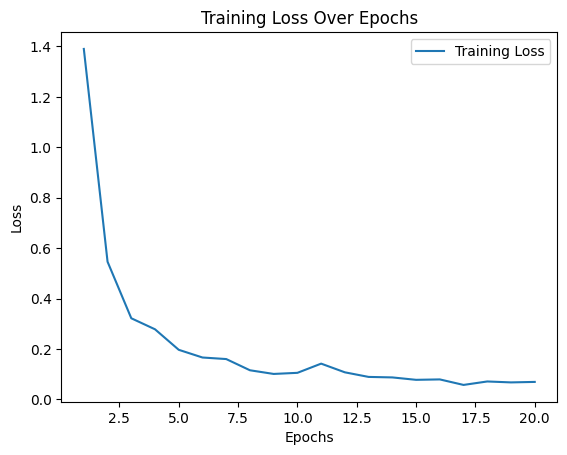

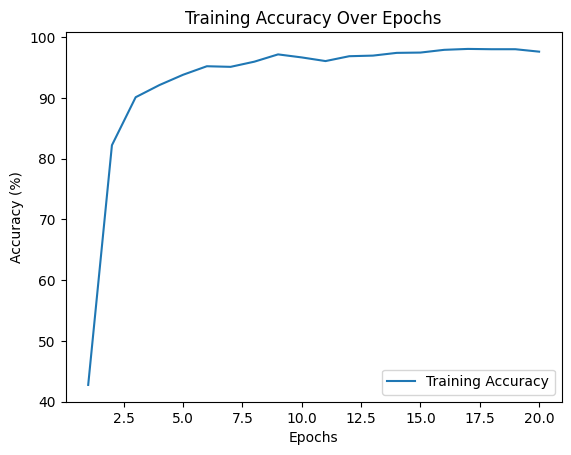

In [24]:
import matplotlib.pyplot as plt

epochs = range(1, num_epochs + 1)

# Plotting Loss
plt.plot(epochs, train_losses, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.show()

# Plotting Accuracy
plt.plot(epochs, train_accuracies, label='Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Training Accuracy Over Epochs')
plt.legend()
plt.show()


<h2> EVALUATE ON TEST-DATA <h2>

In [25]:
def evaluate_model(loader, model):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_x,batch_y in test_loader:
            output = model(batch_x)
            _,predicted = torch.max(output,1)
            total += batch_y.size(0)
            correct += (predicted == batch_y).sum().item()

    accuracy = correct / total
    return accuracy

test_accuracy = evaluate_model(test_loader, model)
print(f"Test Accuracy: {test_accuracy*100:.4f}")


Test Accuracy: 97.6048
